# 🐶🐱 Dogs vs. Cats Image Classification  
**(CNN + Grad-CAM + Hiperparametre Optimizasyonu)**

Bu notebook, Kaggle Dogs vs. Cats veri setinde kedi ve köpekleri ayırt edebilen bir derin öğrenme modeli geliştirmek için hazırlanmıştır.  
Adımlar: veri hazırlama → model oluşturma → eğitim → değerlendirme → görselleştirme → hiperparametre araması → sonuç.


## 1) Kurulum, Yol Yapısı ve Veri Çıkartma

Bu hücre, deney ortamını deterministik hale getirir, Kaggle’da çalışıp çalışmadığını algılar, **Dogs vs. Cats** yarışmasının zip dosyalarını doğru dizinlere **yeniden** çıkartır ve veri boru hattı için temel parametreleri hazırlar.

- **Ortam & Tekrarlanabilirlik:** Python/TensorFlow sürümleri yazdırılır; `SEED=42` ile `random`, `numpy`, `tf` tohumları sabitlenir.
- **Dizin Mantığı:**  
  - Yerel: `data/dogs-vs-cats/`  
  - Kaggle: `/kaggle/input` altında yarışma zip’lerini bulur; çıkış yolu `/kaggle/working/data/dogs-vs-cats/`.
- **Zip Çıkartma (idempotent):**  
  - `CLEAR_OLD=True` ile hedef klasörlerin **içeriği** silinir (klasörler korunur).  
  - `train.zip` → `data/dogs-vs-cats/train/`, `test1.zip` → `data/dogs-vs-cats/test1/`.  
  - Zip içi alt klasör yapısı varsa **düzleştirilir** (tüm `.jpg` dosyaları hedef köke taşınır; çakışmalara isim ekleyerek çözüm).
- **Cache Temizliği:** Yeniden çıkartma sonrası önceki **disk cache** dosyaları (`cache/*.cache`) silinir; veri seti pipeline’ında eski cache’in tutarsızlık yaratması engellenir.
- **Sağlama (Sanity Check):** `train/*.jpg` ve `test1/*.jpg` sayıları kontrol edilir; boşsa açıklayıcı hata mesajıyla durur.
- **Görüntü Parametreleri:**  
  - `IMG_SIZE=224`, `INPUT_SHAPE=(224,224,3)` (CNN giriş boyutu)  
  - `BINARY=True` (ikili sınıflandırma), `BATCH_SIZE=32`  
  - `AUTOTUNE=tf.data.AUTOTUNE` (tf.data pipeline için otomatik paralellik/ön getirme)


In [1]:
import os, sys, glob, random, shutil, math, time, json, zipfile
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

print("Python :", sys.version)
print("TensorFlow :", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

IN_KAGGLE = Path("/kaggle/input").exists()
if IN_KAGGLE:
    candidates = [p for p in Path("/kaggle/input").glob("*") if p.is_dir()]
    comp_root = None
    for c in candidates:
        if (c/"train.zip").exists() and (c/"test1.zip").exists():
            comp_root = c; break
    if comp_root is None:
        raise FileNotFoundError("Couldn't find train.zip & test1.zip under /kaggle/input. Make sure you added the 'Dogs vs Cats' competition on the right panel.")
    DATA_DIR = Path("/kaggle/working/data/dogs-vs-cats")
else:
    DATA_DIR = Path("data/dogs-vs-cats")
    comp_root = None 

RAW_TRAIN_DIR = DATA_DIR / "train"
RAW_TEST_DIR  = DATA_DIR / "test1"
MODELS_DIR    = Path("models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)

CLEAR_OLD = True

def _rm_children(folder: Path):
    """Delete all children of a folder (but keep the folder)."""
    if not folder.exists():
        folder.mkdir(parents=True, exist_ok=True)
        return
    for p in folder.iterdir():
        try:
            if p.is_dir():
                shutil.rmtree(p)
            else:
                p.unlink()
        except Exception as e:
            print(f"[WARN] Could not remove {p}: {e}")

def _extract(zip_path: Path, out_dir: Path, clear_old: bool = CLEAR_OLD):
    out_dir.mkdir(parents=True, exist_ok=True)
    if clear_old:
        print(f"Clearing old contents under: {out_dir}")
        _rm_children(out_dir)

    print(f"Extracting {zip_path.name} -> {out_dir} ...")
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(out_dir)

    inner_dirs = [p for p in out_dir.iterdir() if p.is_dir()]
    if inner_dirs and not any(out_dir.glob("*.jpg")):
        for d in inner_dirs:
            for f in d.rglob("*.jpg"):
                dest = out_dir / f.name
                if dest.exists():
                    dest = out_dir / f"{d.name}__{f.name}"
                f.replace(dest)
            try: shutil.rmtree(d)
            except Exception: pass

if IN_KAGGLE:
    _extract(comp_root / "train.zip", RAW_TRAIN_DIR)
    _extract(comp_root / "test1.zip", RAW_TEST_DIR)

if CLEAR_OLD:
    CACHE_DIR = Path("cache")
    if CACHE_DIR.exists():
        for f in CACHE_DIR.glob("*.cache"):
            try: f.unlink()
            except Exception as e: print(f"[WARN] Could not delete cache {f}: {e}")

n_train = len(list(RAW_TRAIN_DIR.glob("*.jpg")))
n_test  = len(list(RAW_TEST_DIR.glob("*.jpg")))
assert n_train > 0, f"Beklenen klasör yok veya boş: {RAW_TRAIN_DIR}. Kaggle 'train' içeriğini buraya çıkarın."
assert n_test  > 0, f"Beklenen klasör yok veya boş: {RAW_TEST_DIR}. Kaggle 'test1' içeriğini buraya çıkarın."
print("Toplam eğitim görüntüsü:", n_train)
print("Toplam test görüntüsü  :", n_test)

IMG_SIZE   = 224
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BINARY = True
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

2025-09-26 21:51:39.980876: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758923500.348918      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758923500.444821      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Python : 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
TensorFlow : 2.18.0
Num GPUs Available: 2
Clearing old contents under: /kaggle/working/data/dogs-vs-cats/train
Extracting train.zip -> /kaggle/working/data/dogs-vs-cats/train ...
Clearing old contents under: /kaggle/working/data/dogs-vs-cats/test1
Extracting test1.zip -> /kaggle/working/data/dogs-vs-cats/test1 ...
Toplam eğitim görüntüsü: 25000
Toplam test görüntüsü  : 12500


## 2) Veri Hazırlama Pipeline’ı (etiket, ayrım, ön-işleme, augmentasyon, cache)

**Ne yapıyoruz?** Eğitim görsellerinden etiketleri **dosya adından** çıkarıyoruz, veriyi **stratified** şekilde eğitim/doğrulama olarak ayırıyoruz, görüntüleri **decode→resize→normalize** akışına sokuyoruz, **augmentation** uyguluyoruz ve I/O maliyetini azaltmak için **disk tabanlı cache** kullanıyoruz. Son olarak, küçük bir **önizleme** ile boru hattını doğruluyoruz.

- **Etiket çıkarma:**  
  `cat.* → 0`, `dog.* → 1`. Dosya adının prefix’ine bakarak `labels` dizisi üretilir; sınıf isimleri `['cat', 'dog']`.

- **Eğitim/Doğrulama ayrımı (stratify):**  
  `train_test_split(..., test_size=0.2, stratify=labels, random_state=SEED)` ile sınıf oranları korunur; deney tekrarları için tohum sabittir.

- **Ön-işleme (`load_image`):**  
  JPEG okuma → RGB’ye sabitleme (`channels=3`) → `IMG_SIZE×IMG_SIZE` yeniden boyutlandırma → `layers.Rescaling(1./255)` ile `[0,1]` aralığına ölçekleme.  
  Çıkış: `(float32 image, int32 label)` — modele doğrudan beslenebilir.

- **Augmentasyon:**  
  `RandomFlip("horizontal") + RandomRotation(0.05) + RandomZoom(0.1)` ile veri çeşitliliği; sonda `clip [0,1]` (görselleştirme/uyarıları temiz tutmak için).  
  Not: Augmentasyon **cache’ten sonra** uygulanır; decode/resize tekrar hesaplanmaz, yalnızca stochastic transformlar yapılır.

- **Deterministik seçenek:**  
  `tf.data.Options().experimental_deterministic = True` → aynı tohumla aynı örnek sırası (tekrarlanabilirlik).

- **Disk tabanlı cache:**  
  `train.cache` ve `val.cache` dosyalarına **decode/resize/normalize** sonrası ara tensörler yazılır.  
  Fayda: CPU I/O ve tekrar decode maliyetleri azalır; özellikle RAM düşükken eğitimi hızlandırır/istikrarlı kılar.

- **tf.data akışları:**  
  - `train_base = from_tensor_slices → map(load_image) → cache(TRAIN_CACHE)`  
  - `train_ds = train_base → shuffle(2048, seed) → map(augmentation, training=True) → batch(32) → prefetch(AUTOTUNE)`  
  - `val_ds   = from_tensor_slices → map(load_image) → cache(VAL_CACHE) → batch(32) → prefetch(AUTOTUNE)`  
  Bu sıralama **doğru yerlerde** shuffle/augment/batch uygulandığını garanti eder.

- **Kardinalite & günlük:**  
  `tf.data.experimental.cardinality` ile batch sayıları yazdırılır; cache dosya yolları log’lanır (izlenebilirlik).

- **Önizleme (sanity check):**  
  `train_base.take(9)` ile 9 örnek çekilir, `augmentation(training=False)` ile görselleştirilir.  
  Amaç: boru hattının beklenen biçimde çalıştığını *gözle* doğrulamak.

Örnek dosya: cat.0.jpg → etiket: cat
Eğitim: 20000, Doğrulama: 5000


I0000 00:00:1758923599.739677      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758923599.740412      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Disk cache etkin. Cache dosyaları:
  cache/train.cache 
  cache/val.cache
train batches: 625
val batches  : 157


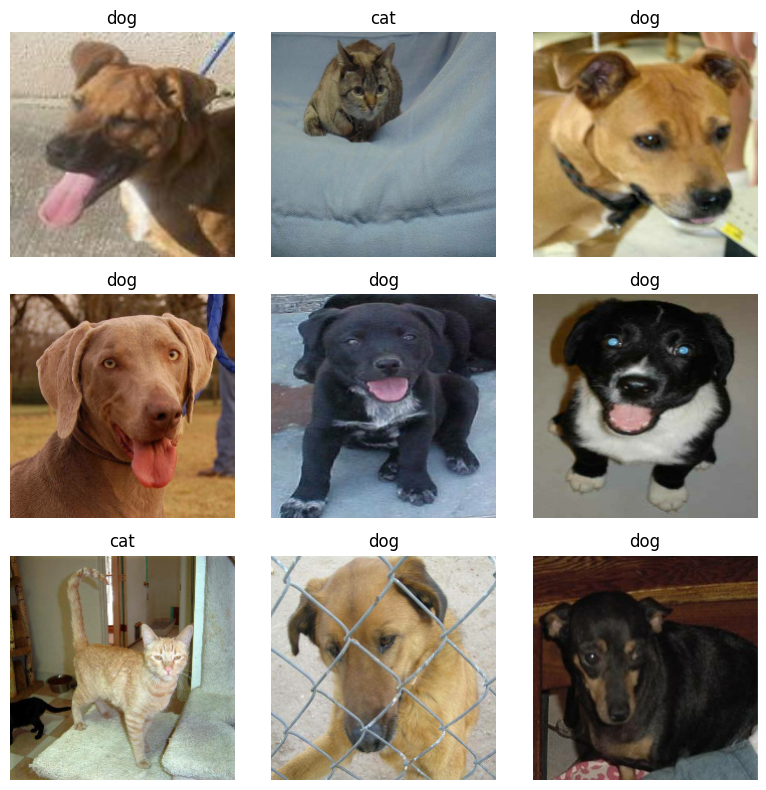

In [2]:
all_files = sorted(glob.glob(str(RAW_TRAIN_DIR / '*.jpg')))
labels = np.array([1 if Path(f).name.startswith('dog') else 0 for f in all_files], dtype=np.int32)
class_names = ['cat', 'dog']
print("Örnek dosya:", Path(all_files[0]).name, "→ etiket:", class_names[labels[0]])

train_files, val_files, y_train, y_val = train_test_split(
    all_files, labels, test_size=0.2, random_state=SEED, stratify=labels
)
print(f"Eğitim: {len(train_files)}, Doğrulama: {len(val_files)}")

# Decode/resize/scale 
RESCALE = layers.Rescaling(1./255)

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = RESCALE(img)  # float32 in [0,1]
    return img, tf.cast(label, tf.int32)

# Augmentasyon 
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.Lambda(lambda x: tf.clip_by_value(x, 0.0, 1.0), name="clip01")
], name="data_augmentation")

opts = tf.data.Options()
opts.experimental_deterministic = True

CACHE_DIR = Path("cache"); CACHE_DIR.mkdir(parents=True, exist_ok=True)
TRAIN_CACHE = str(CACHE_DIR / "train.cache")
VAL_CACHE   = str(CACHE_DIR / "val.cache")

train_base = (tf.data.Dataset.from_tensor_slices((train_files, y_train))
              .map(load_image, num_parallel_calls=AUTOTUNE)
              .with_options(opts)
              .cache(TRAIN_CACHE))

val_ds = (tf.data.Dataset.from_tensor_slices((val_files, y_val))
          .map(load_image, num_parallel_calls=AUTOTUNE)
          .with_options(opts)
          .cache(VAL_CACHE)
          .batch(32)
          .prefetch(AUTOTUNE))
train_ds = (train_base
            .shuffle(2048, seed=SEED, reshuffle_each_iteration=True)
            .map(lambda x, y: (data_augmentation(x, training=True), y),
                 num_parallel_calls=AUTOTUNE)
            .batch(32)
            .prefetch(AUTOTUNE))

print("Disk cache etkin. Cache dosyaları:\n ", TRAIN_CACHE, "\n ", VAL_CACHE)
print("train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("val batches  :", tf.data.experimental.cardinality(val_ds).numpy())

preview_ds = (train_base.take(9)
              .map(lambda x, y: (data_augmentation(x, training=False), y))
              .batch(9))

sample_imgs, sample_labels = next(iter(preview_ds))
imgs_np = np.clip(sample_imgs.numpy(), 0.0, 1.0)

plt.figure(figsize=(8,8))
for i in range(imgs_np.shape[0]):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(imgs_np[i])
    plt.title(class_names[int(sample_labels[i])])
    plt.axis('off')
plt.tight_layout(); plt.show()

## 3) Basit CNN — Mimari ve Tasarım Gerekçeleri

**Ne yapıyor?** ReLU için uygun **HeNormal** başlatma, **L2** cezası, her konv sonrası **BatchNorm**, son konv bloğundan sonra **GlobalAveragePooling (GAP)** ve isimlendirilmiş **last_conv** katmanı ile **Grad-CAM** uyumlu, hafif ama düzenli bir temel CNN kuruyor.

- **Giriş / Hiperparametreler:**  
  `input_shape=(224,224,3)`; kapasiteyi `base_filters` (32→64→128), `kernel_size`, `dropout_rate` ve `dense_units` ile ayarlayabiliyoruz.

- **Ağırlık başlatma ve düzenlileştirme:**  
  - `HeNormal`: ReLU etkinleştirmeleriyle daha iyi gradyan akışı.  
  - `kernel_regularizer=L2(5e-5)`: Ağırlıkları cezalandırarak **overfitting**’i azaltır.  
  - Konv katmanlarında `use_bias=False`: Hemen ardından **BatchNorm** olduğu için gereksiz bias parametresini kaldırır.

- **Konvolüsyon blokları (3 blok):**  
  Her blok: `Conv2D → BatchNorm → ReLU → MaxPool`. Filtreler 1×, 2×, 4× ölçeklenir.  
  - **last_conv** adı verilen son konv katmanı, **Grad-CAM** için hedef katman olarak kullanılacak şekilde **bilinçli isimlendirildi**.

- **Özellikten sınıfa geçiş (Head):**  
  - **GAP (`GlobalAveragePooling2D`)**: `Flatten` yerine kullanılarak parametre sayısını düşürür, **CAM/Grad-CAM** ile uyumluluk sağlar ve aşırı öğrenmeyi azaltır.  
  - **Dropout → Dense(ReLU) → Dropout**: Tam bağlantılı kısımda rastgele devre dışı bırakma ile düzenlileştirme.

- **Çıkış katmanı:**  
  - `BINARY=True` ise `Dense(1, sigmoid)` (ikili sınıflandırma, dogs-vs-cats).  
  - Aksi halde `Dense(num_classes, softmax)` (çok sınıflı senaryolar).

- **Model adı ve özet:**  
  Model `cnn_baseline_v2` olarak adlandırılır; `model.summary()` ile katman boyutları ve parametre sayısı doğrulanır.

In [3]:
def build_simple_cnn(input_shape=INPUT_SHAPE,
                     
                     base_filters=32,
                     kernel_size=3,
                     dropout_rate=0.2,
                     dense_units=128):
    """
    Improved baseline CNN:
    - He-normal initialization (better for ReLU)
    - L2 kernel regularization (reduces overfitting)
    - Batch Normalization after each conv (stabilizes/accelerates training)
    - GlobalAveragePooling2D instead of Flatten (fewer params, CAM-friendly)
    - Keep `last_conv` layer name for Grad‑CAM
    """
    kr = keras.regularizers.l2(5e-5) # noise
    ki = keras.initializers.HeNormal() #? standra

    inputs = layers.Input(shape=input_shape)

    # Block 1
    x = layers.Conv2D(base_filters, kernel_size, padding='same', use_bias=False,
                      kernel_initializer=ki, kernel_regularizer=kr, name='conv1')(inputs)
    x = layers.BatchNormalization(name='bn1')(x)
    x = layers.Activation('relu', name='relu1')(x)
    x = layers.MaxPooling2D(name='pool1')(x)

    # Block 2
    x = layers.Conv2D(base_filters*2, kernel_size, padding='same', use_bias=False,
                      kernel_initializer=ki, kernel_regularizer=kr, name='conv2')(x)
    x = layers.BatchNormalization(name='bn2')(x)
    x = layers.Activation('relu', name='relu2')(x)
    x = layers.MaxPooling2D(name='pool2')(x)

    # Block 3 (keep name for Grad‑CAM)
    x = layers.Conv2D(base_filters*4, kernel_size, padding='same', use_bias=False,
                      kernel_initializer=ki, kernel_regularizer=kr, name='last_conv')(x)
    x = layers.BatchNormalization(name='bn3')(x)
    x = layers.Activation('relu', name='relu3')(x)
    x = layers.MaxPooling2D(name='pool3')(x)

    # Head: GAP -> Dense -> Dropout
    x = layers.GlobalAveragePooling2D(name='gap')(x)
    x = layers.Dropout(dropout_rate, name='dropout_head')(x)
    x = layers.Dense(dense_units, activation='relu', kernel_initializer=ki,
                     kernel_regularizer=kr, name='dense')(x)
    x = layers.Dropout(dropout_rate, name='dropout_out')(x)

    if BINARY:
        outputs = layers.Dense(1, activation='sigmoid', name='out')(x)
    else:
        outputs = layers.Dense(len(class_names), activation='softmax', name='out')(x)

    model = keras.Model(inputs, outputs, name='cnn_baseline_v2')
    return model

model = build_simple_cnn()
model.summary()

Model: "cnn_baseline_v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 224, 224, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 224, 224, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 112, 112, 64)   │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 112, 112, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (Activation)              │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv2D)              │ (None, 56, 56, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 56, 56, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (Activation)              │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_head (Dropout)          │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_out (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (Dense)                     │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,561 (431.88 KB)

 Trainable params: 110,113 (430.13 KB)

 Non-trainable params: 448 (1.75 KB)

## 4) Eğitim Stratejisi — Derleme (compile), Callback’ler ve Fit

**Özet:** Model, **Adam** ile `LR=5e-4` başlangıç öğrenme oranında eğitiliyor; kayıp fonksiyonu **BinaryCrossentropy** (etiket yumuşatma `0.05`), metrikler **accuracy** ve **AUC**. Eğitim akışı **EarlyStopping**, **ReduceLROnPlateau** ve **ModelCheckpoint** ile izlenip iyileştiriliyor.

- **Kayıp (loss) ve etiket yumuşatma:**  
  `BinaryCrossentropy(label_smoothing=0.05)` pozitif/negatif hedefleri tam 0/1 yerine %5 esnetir. Gürültülü/yanılabilir etiketlerde aşırı güveni azaltır, genellemeyi iyileştirebilir.

- **Optimizasyon ve öğrenme oranı:**  
  `Adam(lr=5e-4)` iyi bir başlangıçtır. **ReduceLROnPlateau** doğrulama metriği iyileşmediğinde LR’ı **×0.5** düşürerek yerel plato/oynaklıklarda daha iyi yakınsamayı hedefler.

- **Metrikler:**  
  - `accuracy`: doğru sınıflama oranı.  
  - `AUC`: eşik-bağımsız ayırım gücü; sınıf dengesizliğine karşı daha stabildir.

- **Callback’ler:**  
  - **EarlyStopping** (`patience=3`, `monitor='val_loss'`, `restore_best_weights=True`): Doğrulama kaybı 3 epoch iyileşmezse durur ve **en iyi val_loss**’a ait ağırlıkları geri yükler (overfitting’i sınırlar, süreyi kısaltır).  
  - **ReduceLROnPlateau** (`patience=2`, `factor=0.5`): 2 epoch gelişme yoksa LR’ı yarıya indirir, daha ince adımlarla aramaya devam eder.  
  - **ModelCheckpoint** (`monitor='val_accuracy'`, `save_best_only=True`): En iyi **val_accuracy** görüldüğünde modeli `models/cnn_baseline.keras` olarak kaydeder.  
    > **Not:** EarlyStopping **val_loss**’u, Checkpoint ise **val_accuracy**’yi izliyor. Tek bir hedefe (örn. **val_auc** ya da **val_loss**) hizalamak raporlama tutarlılığını artırır.

- **Adım sayıları (steps):**  
  `steps_per_epoch = ceil(len(train_files)/BATCH_SIZE)` ve `validation_steps` ile her epoch’ta tüm verinin bir kez görülmesi garanti edilir. (Pipeline’ında `.repeat()` yoksa bu hesaplama isabetlidir.)

- **Eğitim çağrısı:**  
  `model.fit(train_ds, validation_data=val_ds, epochs=25, ...)` tarihçeyi `history` içine yazar. Eğitim sonrası `history.history` ile **loss/accuracy/AUC** eğrileri çizilebilir ve en iyi epoch tespit edilebilir.

In [4]:

LR = 5e-4
EPOCHS = 25

loss = keras.losses.BinaryCrossentropy(label_smoothing=0.05)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR),
    loss=loss,
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

callbacks = [
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, verbose=1),
    keras.callbacks.ModelCheckpoint(filepath="models/cnn_baseline.keras",
                                    monitor="val_accuracy", save_best_only=True),
]

from math import ceil
train_steps = ceil(len(train_files) / BATCH_SIZE)
val_steps   = ceil(len(val_files)   / BATCH_SIZE)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/25


I0000 00:00:1758923647.756109      84 service.cc:148] XLA service 0x79ed1400f290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758923647.757828      84 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758923647.757851      84 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758923648.536044      84 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/625 ━━━━━━━━━━━━━━━━━━━━ 43s 70ms/step - accuracy: 0.6484 - auc: 0.6768 - loss: 0.7030   

I0000 00:00:1758923655.194575      84 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 151s 220ms/step - accuracy: 0.5984 - auc: 0.6385 - loss: 0.7165 - val_accuracy: 0.6434 - val_auc: 0.7362 - val_loss: 0.6596 - learning_rate: 5.0000e-04
Epoch 2/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 137s 210ms/step - accuracy: 0.6540 - auc: 0.7132 - loss: 0.6580 - val_accuracy: 0.6296 - val_auc: 0.7507 - val_loss: 0.6664 - learning_rate: 5.0000e-04
Epoch 3/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 135s 208ms/step - accuracy: 0.6687 - auc: 0.7409 - loss: 0.6376 - val_accuracy: 0.6840 - val_auc: 0.7900 - val_loss: 0.6207 - learning_rate: 5.0000e-04
Epoch 4/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 209ms/step - accuracy: 0.6899 - auc: 0.7584 - loss: 0.6232 - val_accuracy: 0.6080 - val_auc: 0.7814 - val_loss: 0.6907 - learning_rate: 5.0000e-04
Epoch 5/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.7067 - auc: 0.7769 - loss: 0.6083
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
625/625 ━━━━━━━━━━━━━━━━━━━━ 134s 206ms/step - accuracy: 0.7067 -

## 5) Eğitim Eğrileri — Loss & Accuracy Yorumlama

**Ne gösterir?** `history.history` içinden **eğitim** ve **doğrulama** için epoch bazında iki eğri çizer:
- **Loss per epoch:** Öğrenmenin istikrarlı ilerleyip ilerlemediğini; **overfitting**’i (train loss ↓, val loss ↑) ya da **underfitting**’i (her iki loss da yüksek seyir) görürüz.
- **Accuracy per epoch:** Sınıflama başarısının genel trendini izleriz; train–val farkı büyüyorsa aşırı uyum belirtisi olabilir.

**Nasıl okunur?**
- Sağlıklı bir eğitimde **train loss** ve **val loss** birlikte azalır; epoch ilerledikçe aradaki fark **makul** kalır.
- **EarlyStopping** etkinse, model ağırlıkları en iyi **val_loss** epoch’una geri yüklenir; grafikte en düşük **val_loss** noktası kritik referanstır.
- **Accuracy** grafiğinde train–val uçurumu büyürse, **daha fazla düzenlileştirme** (Dropout↑, L2↑, augmentation↑) veya **LR azaltımı** gerekebilir.


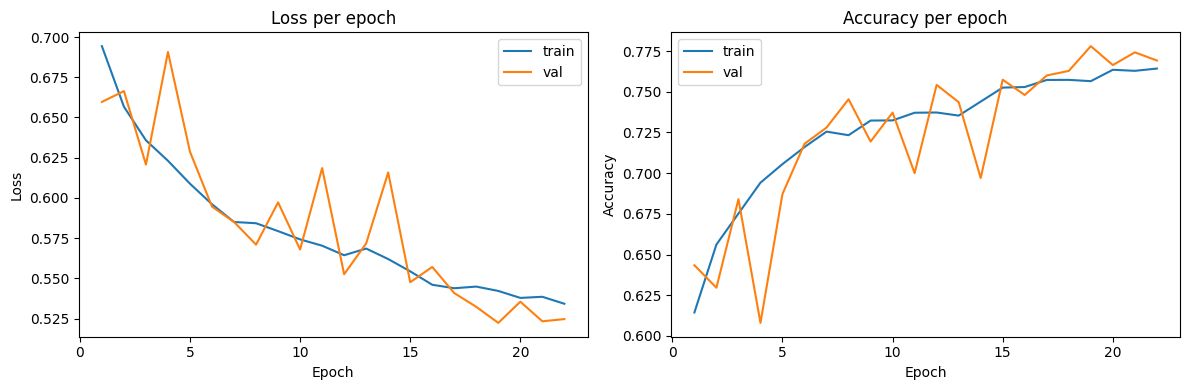

In [5]:

def plot_training_curves(history):
    hist = history.history
    epochs = range(1, len(hist['loss'])+1)

    plt.figure(figsize=(12,4))
    # Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, hist['loss'], label='train')
    plt.plot(epochs, hist['val_loss'], label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per epoch')
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, hist['accuracy'], label='train')
    plt.plot(epochs, hist['val_accuracy'], label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(history)


## 6) Doğrulama Değerlendirmesi — Sınıflandırma Raporu & Karışıklık Matrisi

**Ne yapıyoruz?** `val_ds` üzerinde modelin olasılık çıkışlarını alıp (`probs`), **eşik=0.5** ile sınıfa çeviriyoruz (`preds`). Ardından **precision/recall/F1**’ı içeren `classification_report` ve hata türlerini görselleyen **confusion matrix** üretiyoruz.

- **Tahmin akışı:**
  - `model.predict(imgs)` → `probs ∈ [0,1]` (sigmoid çıkışı).  
  - `preds = (probs ≥ 0.5)` → ikili sınıf etiketi.  
  - `y_true` gerçek etiketler; `y_pred` model tahminleri.

- **Sınıflandırma raporu (`classification_report`):**  
  - **precision (kesinlik):** Pozitif dediğinin ne kadarının doğru olduğu.  
  - **recall (duyarlılık):** Gerçek pozitiflerin ne kadarını yakaladığın.  
  - **F1:** Precision & recall’ın harmonik ortalaması (dengesiz veri için faydalı).  
  - **support:** Her sınıftaki örnek sayısı (raporu okurken sınıf dengesiyle birlikte düşün).

- **Karışıklık matrisi (Confusion Matrix):**  
  - Köşegen elemanlar: **doğru** sınıflamalar.  
  - Üst sağ: Gerçekte **cat**, tahmin **dog** (**false positive** for dog).  
  - Alt sol: Gerçekte **dog**, tahmin **cat** (**false negative** for dog).

              precision    recall  f1-score   support

         cat     0.7538    0.8256    0.7881      2500
         dog     0.8073    0.7304    0.7669      2500

    accuracy                         0.7780      5000
   macro avg     0.7805    0.7780    0.7775      5000
weighted avg     0.7805    0.7780    0.7775      5000



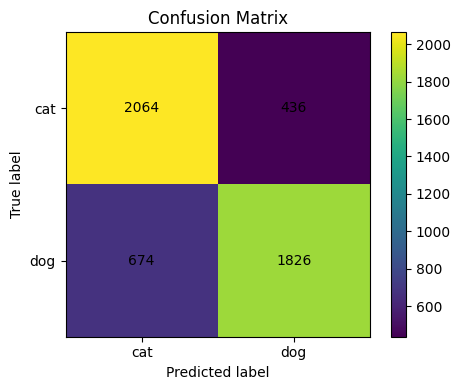

In [6]:
y_true = []
y_pred = []

for imgs, labels in val_ds:
    probs = model.predict(imgs, verbose=0).ravel()
    preds = (probs >= 0.5).astype(int)
    y_true.extend(labels.numpy().astype(int).tolist())
    y_pred.extend(preds.tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       xlabel='Predicted label', ylabel='True label', title='Confusion Matrix')

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center")
plt.tight_layout()
plt.show()

## 7) Açıklanabilirlik — Grad-CAM (son konv katmanı: `last_conv`)

**Amaç:** Modelin kararı verirken görüntünün **hangi bölgelerine** odaklandığını ısı haritası ile göstermek. Bu uygulama, mimaride bilinçli olarak isimlendirdiğimiz `last_conv` katmanını hedef alır ve **GAP** ile uyumludur.

**Nasıl çalışır?**
1. `grad_model`: Girdi → (`last_conv` aktivasyonları, `model.output`) ikilisini döndüren yardımcı bir model kurulur.
2. `GradientTape`: İlgili sınıfın çıkış skoru (ikili görevde `predictions[:,0]`) ile `last_conv` aktivasyonları arasındaki **gradyan** alınır.
3. **Kanal ağırlıkları:** Gradyanlar uzamsal ortalama ile kanallara indirgenir → `pooled_grads (C,)`.
4. **Sınıf aktivasyon haritası:** `conv_outputs` kanalları, ağırlıklarla çarpılıp toplanır → **ısı haritası**.
5. **Normalize & ReLU:** Negatif değerler sıfırlanır; [0,1] aralığına normalize edilir ve orijinal görüntü üstüne `alpha≈0.4` ile bindirilir.

**Fonksiyonlar:**
- `get_img_array(path)`: Görüntüyü okur, `IMG_SIZE×IMG_SIZE`’a yeniden boyutlandırır, `[0,1]`’e ölçekler.
- `make_gradcam_heatmap(img_array, model, last_conv_layer_name)`: Yukarıdaki akışla ısı haritasını üretir (NumPy).
- `show_gradcam(image_path, model, last_conv_layer_name)`: Girdi ve bindirilmiş ısı haritasını yan yana çizer.


Örnek: cat.2100.jpg


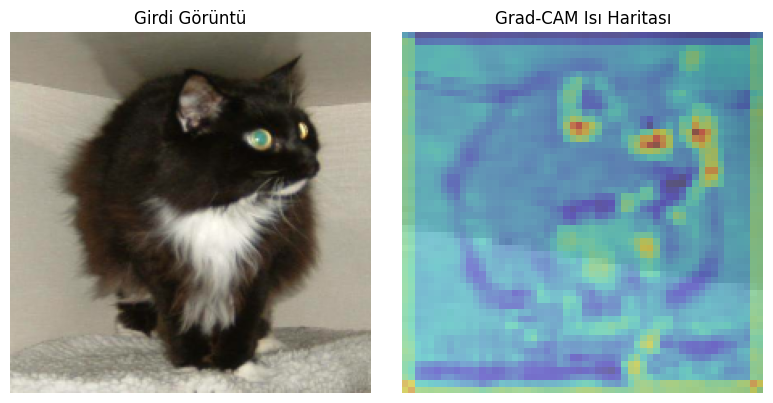

In [12]:
def get_img_array(path, size=(IMG_SIZE, IMG_SIZE)):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, size)
    img = tf.cast(img, tf.float32)/255.0
    return img.numpy()

def make_gradcam_heatmap(img_array, model, last_conv_layer_name='last_conv'):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(tf.expand_dims(img_array, axis=0), training=False)
        if BINARY:
            loss = predictions[:, 0]
        else:
            class_idx = tf.argmax(predictions[0])
            loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)[0]              # (H, W, C)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))         # (C,)

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def show_gradcam(image_path, model, last_conv_layer_name='last_conv'):
    img = get_img_array(image_path, size=(IMG_SIZE, IMG_SIZE))
    heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)

    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(img)
    ax1.set_title("Girdi Görüntü")
    ax1.axis('off')

    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(img)
    ax2.imshow(heatmap, cmap='jet', alpha=0.4)
    ax2.set_title("Grad‑CAM Isı Haritası")
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

example_path = val_files[89]
print("Örnek:", Path(example_path).name)
show_gradcam(example_path, model, last_conv_layer_name='last_conv')

## 8) Transfer Learning (MobileNetV2) (Mini Kullanım)

**Amaç:** Önceden ImageNet üzerinde eğitilmiş **MobileNetV2** gövdesinin genelleme gücünden yararlanıp, üstüne hafif bir sınıflandırıcı başlık (GAP → Dense → Dropout → Sigmoid) ekleyerek daha hızlı ve daha iyi başlangıç performansı elde etmek.

**Kurgu:**
- `USE_TL=False/True` anahtarı ile transfer learning yolu aç/kapat.
- `include_top=False` + **dondurulmuş** (`base.trainable=False`) MobileNetV2 gövdesi.
- Girişe `layers.Resizing(224,224)`; gövdeden sonra `GlobalAveragePooling2D` → `Dropout(0.3)` → `Dense(128, relu)` → `Dropout(0.3)` → `Dense(1, sigmoid)`.

**Eğitim ayarları:**
- `optimizer=Adam(1e-3)`, `loss='binary_crossentropy'`, `metrics=['accuracy']`.
- `EarlyStopping(patience=2, restore_best_weights=True)` ve
  `ModelCheckpoint(..., monitor='val_accuracy', save_best_only=True)`.
- 8 epoch’luk kısa bir **ısınma eğitimi** (frozen gövde ile).

**Not:** Ufak bir örnekle gösterilmiştir


/tmp/ipykernel_36/3354688084.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/8


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_36']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


625/625 ━━━━━━━━━━━━━━━━━━━━ 134s 184ms/step - accuracy: 0.9535 - loss: 0.1175 - val_accuracy: 0.9838 - val_loss: 0.0420
Epoch 2/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 115s 174ms/step - accuracy: 0.9736 - loss: 0.0683 - val_accuracy: 0.9838 - val_loss: 0.0388
Epoch 3/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 115s 175ms/step - accuracy: 0.9737 - loss: 0.0641 - val_accuracy: 0.9850 - val_loss: 0.0373
Epoch 4/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 115s 175ms/step - accuracy: 0.9771 - loss: 0.0605 - val_accuracy: 0.9858 - val_loss: 0.0362
Epoch 5/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 115s 174ms/step - accuracy: 0.9777 - loss: 0.0548 - val_accuracy: 0.9840 - val_loss: 0.0395
Epoch 6/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 115s 174ms/step - accuracy: 0.9772 - loss: 0.0562 - val_accuracy: 0.9860 - val_loss: 0.0386


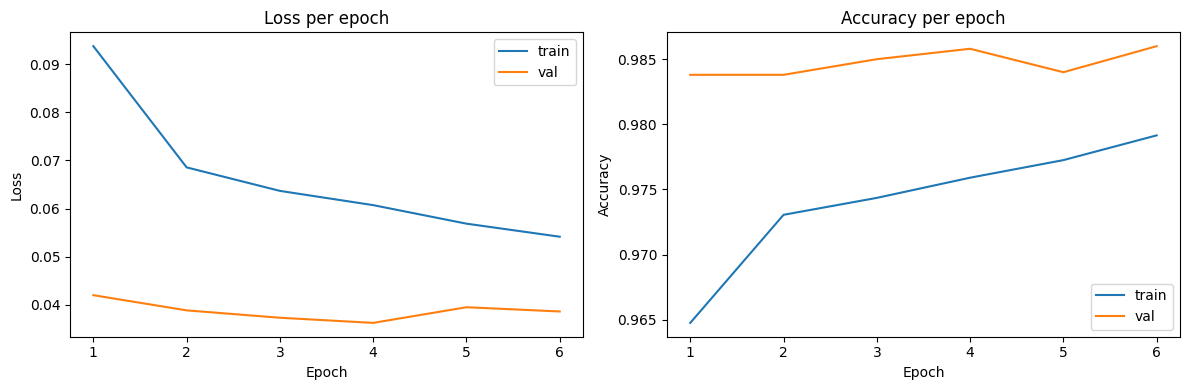

In [20]:
USE_TL = True

if USE_TL:
    IMG_TL = 224
    tl_input = layers.Input(shape=(IMG_TL, IMG_TL, 3))
    base = keras.applications.MobileNetV2(
        input_tensor=tl_input, include_top=False, weights='imagenet')
    base.trainable = False

    tl_model = keras.Sequential([
        layers.Resizing(IMG_TL, IMG_TL),
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ], name="mobilenetv2_transfer")

    tl_model.compile(optimizer=keras.optimizers.Adam(1e-3),
                     loss='binary_crossentropy', metrics=['accuracy'])

    tl_history = tl_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=8,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True),
            keras.callbacks.ModelCheckpoint(str(MODELS_DIR/'mobilenetv2_tl.h5'),
                                            monitor='val_accuracy', save_best_only=True)
        ]
    )

    plot_training_curves(tl_history)

## 9) Hiperparametre Optimizasyonu
Farklı yapılandırmalar denenerek en iyi model seçilir.  
Amaç: performansı artırmak.

- Parametreler: filtre sayısı, kernel boyutu, dropout, dense units, learning rate  
- Yöntem: Keras Tuner Hyperband  
- Sonuç: doğrulama metriklerinde artış sağlayan en iyi yapı

KerasTuner Hyperband kullanarak build_simple_cnn için otomatik arama yapar.

- Hız için küçük bir alt-küme ile (take) arama yapılır; en iyi hiperparametreler bulunduğunda tam veride yeniden eğitebilirsiniz.
- CPU ortamında süreci kısaltmak için max_epochs=6, EarlyStopping(patience=2) ve azaltılmış steps_per_epoch/validation_steps kullanılmıştır.

In [13]:
import keras_tuner as kt

def build_model(hp):
    base_filters = hp.Choice("base_filters", [16, 32, 64])
    kernel_size  = hp.Choice("kernel_size",  [3, 5])
    dropout_rate = hp.Choice("dropout_rate", [0.3, 0.5])
    dense_units  = hp.Choice("dense_units",  [64, 128, 256])
    lr           = hp.Choice("lr",           [1e-3, 5e-4, 1e-4])

    m = build_simple_cnn(base_filters=base_filters,
                         kernel_size=kernel_size,
                         dropout_rate=dropout_rate,
                         dense_units=dense_units)
    m.compile(optimizer=keras.optimizers.Adam(lr),
              loss='binary_crossentropy', metrics=['accuracy'])
    return m

HPO_TRAIN_SAMPLES = 800
HPO_VAL_SAMPLES   = 200
HPO_BATCH_SIZE    = 32

tr_small = (tf.data.Dataset.from_tensor_slices((train_files, y_train))
            .shuffle(2048, seed=SEED)
            .map(load_image, num_parallel_calls=AUTOTUNE)
            .map(lambda x,y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
            .take(HPO_TRAIN_SAMPLES)
            .batch(HPO_BATCH_SIZE)
            .repeat()
            .prefetch(AUTOTUNE))

va_small = (tf.data.Dataset.from_tensor_slices((val_files, y_val))
            .map(load_image, num_parallel_calls=AUTOTUNE)
            .take(HPO_VAL_SAMPLES)
            .batch(HPO_BATCH_SIZE)
            .repeat()
            .prefetch(AUTOTUNE))

STEPS_PER_EPOCH    = HPO_TRAIN_SAMPLES // HPO_BATCH_SIZE
VAL_STEPS_PER_EPOCH = HPO_VAL_SAMPLES // HPO_BATCH_SIZE

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=6,        
    factor=3,
    directory=str(MODELS_DIR / 'kt'),
    project_name='dogs_vs_cats'
)

early = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
print(f"[KT] Arama başlıyor… steps/epoch={STEPS_PER_EPOCH}, val_steps={VAL_STEPS_PER_EPOCH}")
tuner.search(
    tr_small,
    validation_data=va_small,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VAL_STEPS_PER_EPOCH,
    epochs=6,
    callbacks=[early],
    verbose=1
)

best_hp = tuner.get_best_hyperparameters(1)[0]
best_cfg = {k: best_hp.get(k) for k in ["base_filters","kernel_size","dropout_rate","dense_units","lr"]}
print("[KT] En iyi hiperparametreler:", best_cfg)

(MODELS_DIR / 'kt').mkdir(parents=True, exist_ok=True)
with open(MODELS_DIR / 'kt' / 'best_hparams.json', 'w') as f:
    json.dump(best_cfg, f, indent=2)
print(f"[KT] Hiperparametreler kaydedildi: {MODELS_DIR / 'kt' / 'best_hparams.json'}")

best_model = tuner.hypermodel.build(best_hp)
best_model.summary()



Trial 10 Complete [00h 00m 28s]
val_accuracy: 0.5052083134651184

Best val_accuracy So Far: 0.6041666865348816
Total elapsed time: 00h 04m 33s
[KT] En iyi hiperparametreler: {'base_filters': 32, 'kernel_size': 5, 'dropout_rate': 0.3, 'dense_units': 128, 'lr': 0.0001}
[KT] Hiperparametreler kaydedildi: models/kt/best_hparams.json


Model: "cnn_baseline_v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 224, 224, 32)   │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 224, 224, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 112, 112, 64)   │        51,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 112, 112, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (Activation)              │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv2D)              │ (None, 56, 56, 128)    │       204,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 56, 56, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (Activation)              │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_head (Dropout)          │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_out (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (Dense)                     │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 275,937 (1.05 MB)

 Trainable params: 275,489 (1.05 MB)

 Non-trainable params: 448 (1.75 KB)

## 10) Doğrulama Metrikleri — Tek Noktadan Toplama (thresh=0.5) ve Raporlama

**Amaç:** `val_ds` üzerinde **tek fonksiyon** ile gerçek etiketler (`y_true`), model olasılıkları (`y_prob`) ve sınıf tahminleri (`y_pred`) toplanır; ardından **Accuracy, Precision/Recall/F1 (macro)** ve **AUC** hesaplanır. Karışıklık matrisi ve ayrıntılı sınıf raporu da yazdırılır.

**Toplama mantığı (`collect_preds`)**
- **repeat senaryoları:** Dataset `.repeat()` ile sonsuz ise, `max_batches=val_steps` verilerek **tam bir epoch** uzunluğunda veri çekilir. Aksi halde döngü durmaz.
- **çıktı biçimi:**  
  - İkili durumda (sigmoid çıkış) `y_prob` tek boyutlu/tek sütunlu olabilir → `p1 = y_prob.reshape(-1)` ile düzleştirilir.  
  - Çok sınıflıda (softmax) `y_pred = argmax(y_prob, axis=1)`.
- **eşik:** İkili sınıflamada varsayılan **0.5** eşiği ile `y_pred` üretilir.

**Metrikler**
- `Accuracy`: genel doğruluk.  
- `Precision/Recall/F1 (macro)`: Sınıf başına metriklerin ortalaması; **sınıf dengesizliğine** duyarlıdır (her sınıfa eşit ağırlık verir).  
- `AUC` (yalnızca ikili): `roc_auc_score(y_true, p1)`; **eşik-bağımsız** ayırım gücünü gösterir.

**Raporlar**
- `classification_report(digits=4)`: sınıf-bazlı P/R/F1 ve macro/weighted özetleri.  
- `confusion_matrix`: TP/FP/FN/TN dağılımını **somut** gösterir; eşik ve augmentation kararlarını yönlendirir.

**Dikkat / İpuçları**
- **repeat + steps hizası:** `.repeat()` kullanıyorsan `max_batches=val_steps` **zorunlu**; aksi halde birden fazla epoch’luk veri toplanır ve metrikler şişer.  
- **eşik ayarı:** 0.5 her zaman optimal değildir. Hedef metrik (örn. **F1-macro** veya **Youden J**) maksimize edilerek **en iyi eşik** bulunabilir.  
- **AUC ve kalibrasyon:** AUC yüksek ama F1 düşükse, sınıf eşiğini yeniden ayarla; olasılık kalibrasyonu (Platt/Isotonic) gerekli olabilir.  
- **dtype/şekil:** `y_true` ve `y_pred` vektörlerinin **aynı uzunlukta** ve **1D** olduğundan emin olun (reshape/astype adımları bu yüzden var).


In [19]:
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, roc_auc_score
)

def collect_preds(model, dataset, num_classes=None, max_batches=None):
    """
    dataset .repeat() ile sonsuzsa max_batches=val_steps verin.
    """
    y_true_all, y_prob_all = [], []
    for i, (xb, yb) in enumerate(dataset):
        probs = model.predict(xb, verbose=0)
        y_true_all.append(yb.numpy() if hasattr(yb, "numpy") else yb)
        y_prob_all.append(probs)
        if max_batches is not None and (i + 1) >= max_batches:
            break

    y_true = np.concatenate([np.asarray(t).reshape(-1) for t in y_true_all])
    y_prob = np.concatenate(y_prob_all)

    # Sınıf sayısını/çıkış biçimini çıkar
    if num_classes is None:
        n_out = 1 if y_prob.ndim == 1 else y_prob.shape[-1]
        num_classes = 2 if n_out == 1 else n_out

    # Sınıf tahmini
    if num_classes == 2:
        p1 = y_prob.reshape(-1) if y_prob.ndim > 1 else y_prob
        y_pred = (p1 >= 0.5).astype(int)
    else:
        y_pred = np.argmax(y_prob, axis=1)

    return y_true, y_pred, y_prob, num_classes

# Eğer val_ds .repeat() kullanıyorsa ve daha önce val_steps hesapladıysanız, aşağıdaki çağrıda max_batches=val_steps kullanın.
try:
    y_true, y_pred, y_prob, NUM_CLASSES = collect_preds(model, val_ds, max_batches=val_steps)
except NameError:
    # val_steps yoksa normal topla (val_ds sonsuz olmamalı)
    y_true, y_pred, y_prob, NUM_CLASSES = collect_preds(model, val_ds)

# Metrikler
acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="macro", zero_division=0
)

auc_val = None
if NUM_CLASSES == 2:
    try:
        p1 = y_prob.reshape(-1) if y_prob.ndim > 1 else y_prob
        auc_val = roc_auc_score(y_true, p1)
    except Exception:
        auc_val = None

print("\n=========== BAŞARI ÇIKTISI ===========")
print(f"F1-macro: {f1:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision (macro): {prec:.4f}")
print(f"Recall (macro): {rec:.4f}")
if auc_val is not None:
    print(f"AUC: {auc_val:.4f}")
print("======================================\n")

print("— Ayrıntılı Rapor —")
print(classification_report(y_true, y_pred, digits=4))

print("— Confusion Matrix —")
print(confusion_matrix(y_true, y_pred))


=========== BAŞARI ÇIKTISI ===========
F1-macro: 0.7775
Accuracy: 0.7780
Precision (macro): 0.7805
Recall (macro): 0.7780
AUC: 0.8572

— Ayrıntılı Rapor —
              precision    recall  f1-score   support

           0     0.7538    0.8256    0.7881      2500
           1     0.8073    0.7304    0.7669      2500

    accuracy                         0.7780      5000
   macro avg     0.7805    0.7780    0.7775      5000
weighted avg     0.7805    0.7780    0.7775      5000

— Confusion Matrix —
[[2064  436]
 [ 674 1826]]
